<a href="https://colab.research.google.com/github/Akshatpattiwar512/Recurrent-Neural-Network/blob/main/Time_Series_Forecasting_Using_Recurrent_Neural_Networks(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys

In [ ]:
print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.5.0
Pandas Version: 1.1.5
Numpy Version: 1.19.5
System Version: 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]


In [ ]:
# Data Loader Parameters
BATCH_SIZE = 256
BUFFER_SIZE = 10000
TRAIN_SPLIT = 300000

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 4
PATIENCE = 5

# Reproducibility
SEED = 13
tf.random.set_seed(SEED)

## Downloading Weather Dataset

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)
print("DataFrame Shape: {} rows, {} columns".format(*df.shape))
display(df.head())

13574144/13568290 [==============================] - 1s 0us/step
DataFrame Shape: 420551 rows, 15 columns


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Forecasting Univariate Time Series

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

In [ ]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

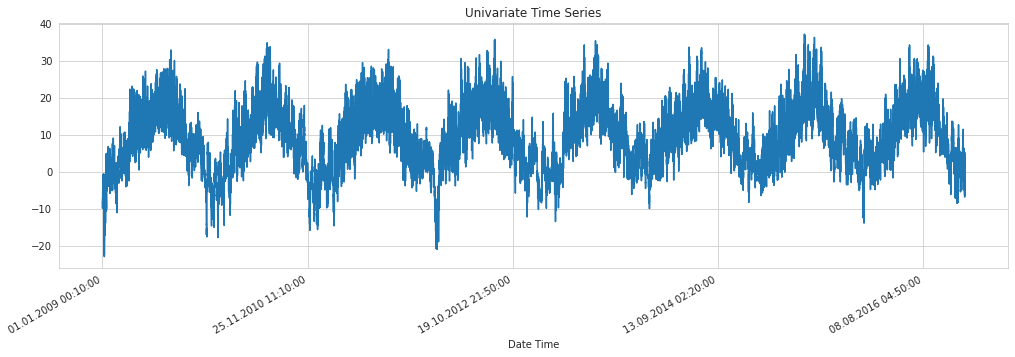

In [ ]:
uni_data.plot(subplots=True)
plt.title("Univariate Time Series")
plt.show()
uni_data = uni_data.values

In [ ]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [ ]:
#standardize the data
uni_data = (uni_data-uni_train_mean)/uni_train_std

## Data Creation for univariate model

In [ ]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(dataset=uni_data,
                                           start_index=0,
                                           end_index=TRAIN_SPLIT,
                                           history_size=univariate_past_history,
                                           target_size=univariate_future_target)
x_val_uni, y_val_uni = univariate_data(dataset=uni_data,
                                       start_index=TRAIN_SPLIT,
                                       end_index=None,
                                       history_size=univariate_past_history,
                                       target_size=univariate_future_target)


In [ ]:
print("In:")
print(uni_data.shape)
print(uni_data[:5])

print("\nOut")
print(x_train_uni.shape)


print(x_train_uni.shape[0] / uni_data.shape[0])

In:
(420551,)
[-1.99766294 -2.04281897 -2.05439744 -2.0312405  -2.02660912]

Out
(299980, 20, 1)
0.7133023105402199


In [ ]:
print ('Single window of past history. Shape: {}'.format(x_train_uni[0].shape))
print (x_train_uni[0])
print ('\n Target temperature to predict. Shape: {}'.format(y_train_uni[0].shape))
print (y_train_uni[0])

Single window of past history. Shape: (20, 1)
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict. Shape: ()
-2.1041848598100876


In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

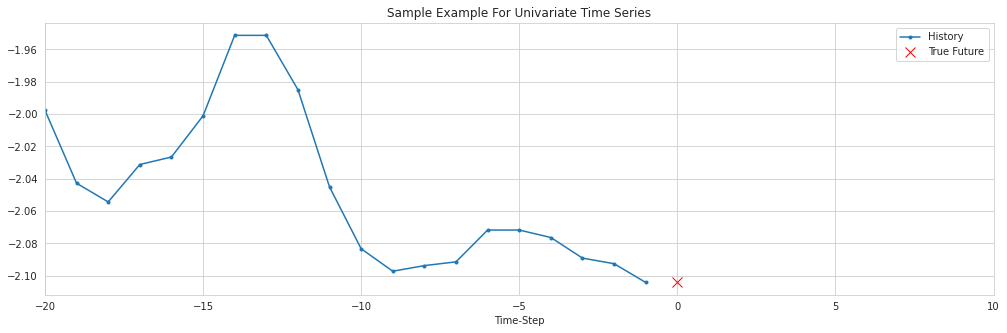

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example For Univariate Time Series')

## Setting Baseline

In [ ]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

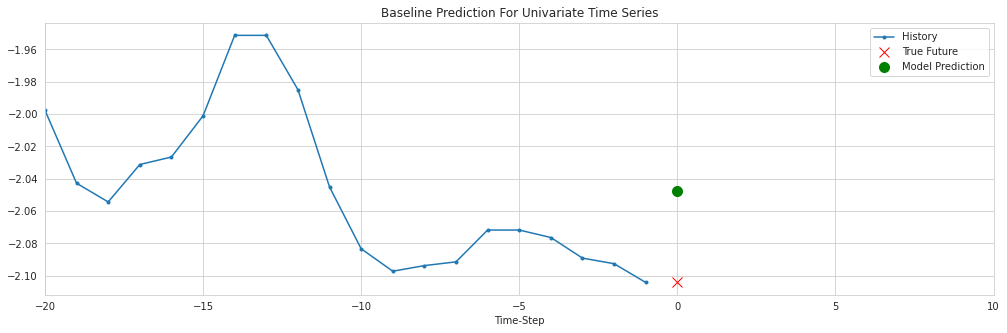

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction For Univariate Time Series')

## Recurrent Neural Network

In [ ]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()


In [ ]:
x_train_uni.shape

(299980, 20, 1)

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [ ]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


## Model Training

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
simple_lstm_model.fit(train_univariate,
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate,
                      callbacks=[early_stopping],
                      validation_steps=50)

Epoch 1/4
200/200 [==============================] - 5s 14ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/4
200/200 [==============================] - 2s 12ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/4
200/200 [==============================] - 2s 12ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/4
200/200 [==============================] - 2s 11ms/step - loss: 0.0443 - val_loss: 0.0258


## Predict using the simple LSTM model

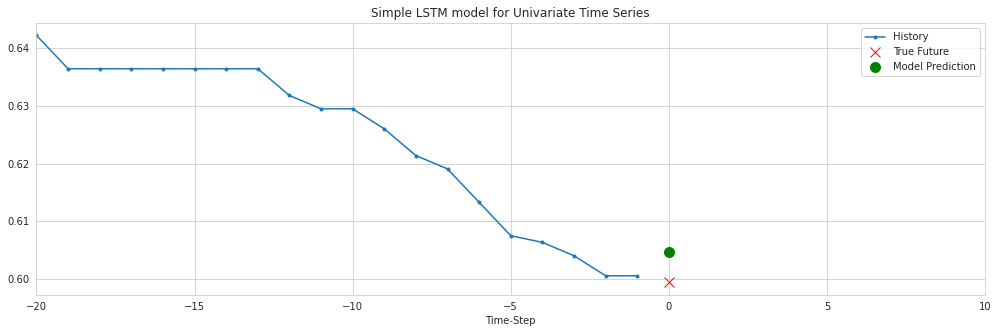

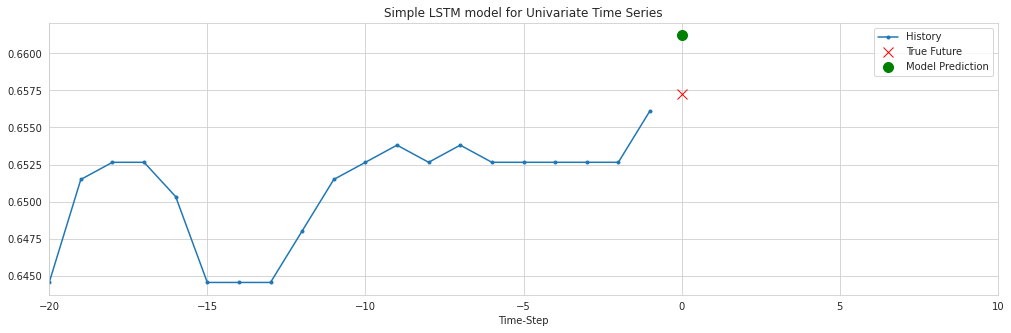

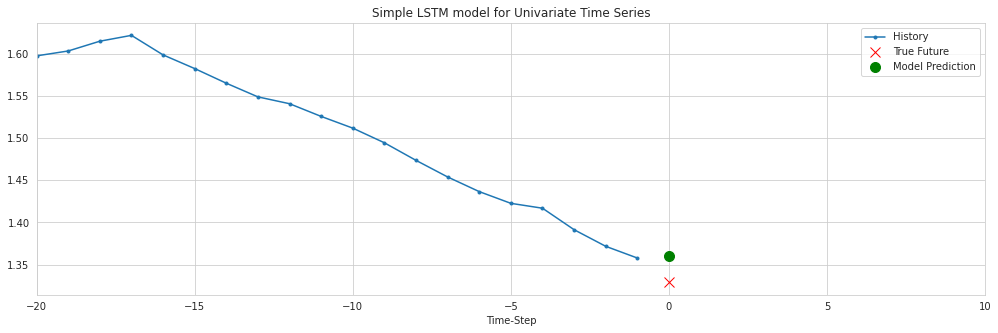

In [ ]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model for Univariate Time Series')
    plot.show()

## Forecasting a Multivariate Time Series

In [ ]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [ ]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f61bd2cda90>,
      dtype=object)

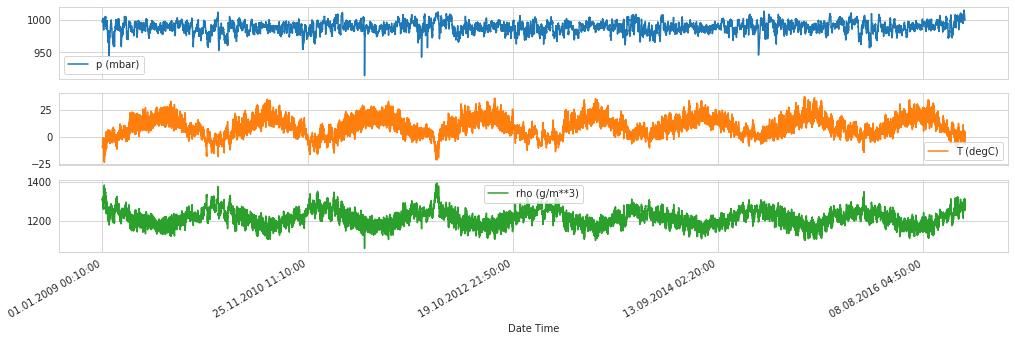

In [ ]:
features.plot(subplots=True)

In [ ]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [ ]:
display(pd.DataFrame(dataset, columns = features.columns, index= features.index).head())

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,0.955474,-1.997663,2.235079
01.01.2009 00:20:00,0.961545,-2.042819,2.285240
01.01.2009 00:30:00,0.956688,-2.054397,2.296006
01.01.2009 00:40:00,0.954259,-2.031241,2.270314
01.01.2009 00:50:00,0.954259,-2.026609,2.265665


## Single Step Model

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [ ]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [ ]:
print(x_train_single.shape)
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print(x_train_single.shape[-2:])

(299280, 120, 3)
Single window of past history : (120, 3)
(120, 3)


In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [ ]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [ ]:
print(f"Evaluation Threshold: {EVALUATION_INTERVAL}",
      f"Epochs: {EPOCHS}", sep="\n")

early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
single_step_history = single_step_model.fit(train_data_single,
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            callbacks=[early_stopping],
                                            validation_steps=50)

Evaluation Threshold: 200
Epochs: 4
Epoch 1/4
200/200 [==============================] - 25s 115ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/4
200/200 [==============================] - 23s 114ms/step - loss: 0.2623 - val_loss: 0.2421
Epoch 3/4
200/200 [==============================] - 23s 113ms/step - loss: 0.2611 - val_loss: 0.2448
Epoch 4/4
200/200 [==============================] - 24s 119ms/step - loss: 0.2568 - val_loss: 0.2447


In [ ]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

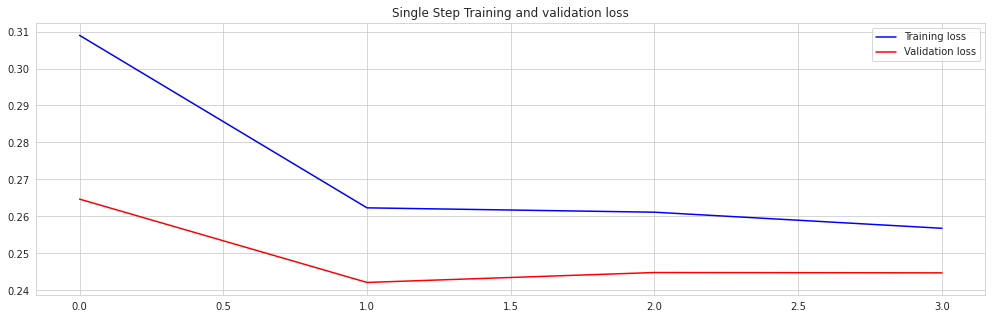

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

## Predict a Single Step Future

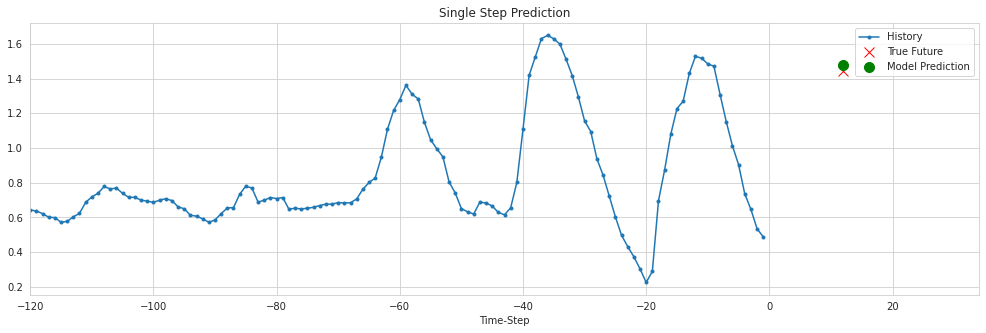

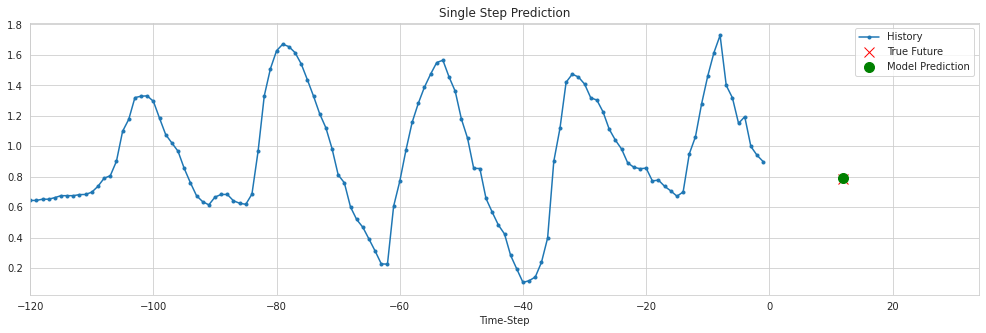

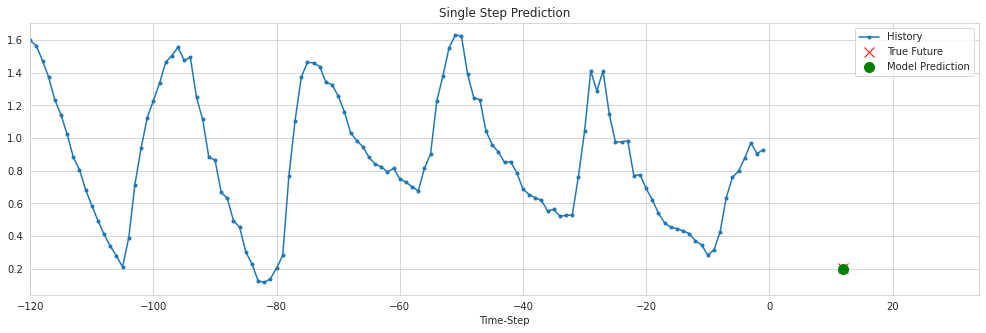

In [ ]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

## Multi-Step Model

In [ ]:
past_history = 720
future_target = 72
STEP = 6

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [ ]:
print (x_train_multi.shape,
       y_train_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target temperature to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(299280, 120, 3)
(299280, 72)
Single window of past history : (120, 3)
Target temperature to predict : (72,)


In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

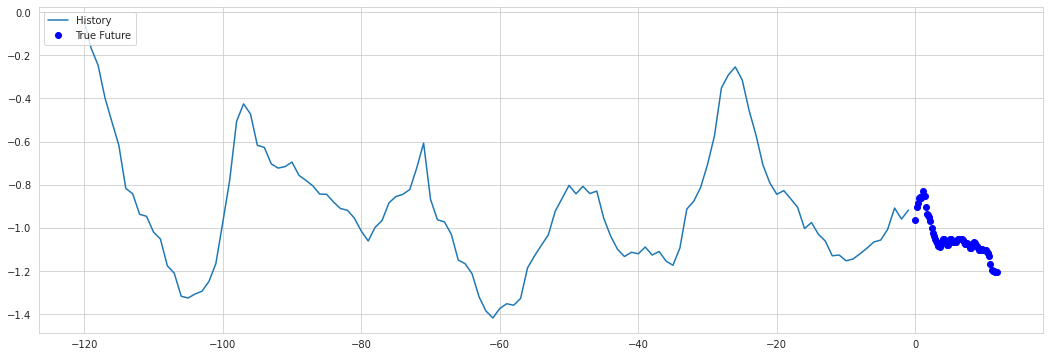

In [ ]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
print(multi_step_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 120, 32)           4608      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 72)                1224      
Total params: 8,968
Trainable params: 8,968
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(256, 72)


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=EVALUATION_INTERVAL,
                                          callbacks=[early_stopping])

Epoch 1/4
200/200 [==============================] - 53s 251ms/step - loss: 0.4949 - val_loss: 0.4060
Epoch 2/4
200/200 [==============================] - 49s 246ms/step - loss: 0.3465 - val_loss: 0.3597
Epoch 3/4
200/200 [==============================] - 49s 245ms/step - loss: 0.3290 - val_loss: 0.2819
Epoch 4/4
200/200 [==============================] - 49s 246ms/step - loss: 0.2431 - val_loss: 0.2448


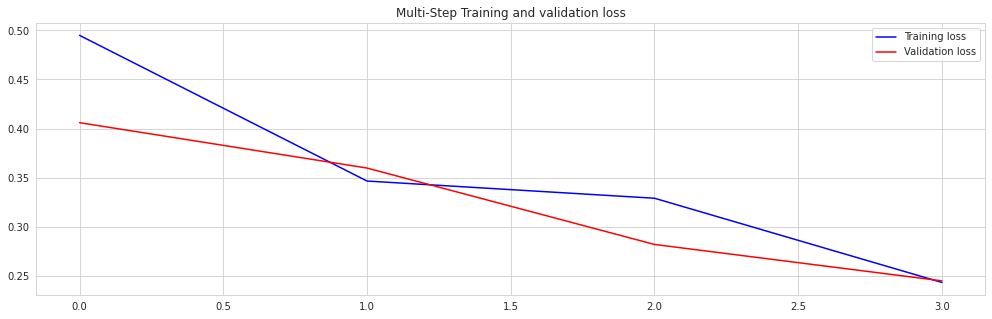

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

## Predict a Multi-Step Future

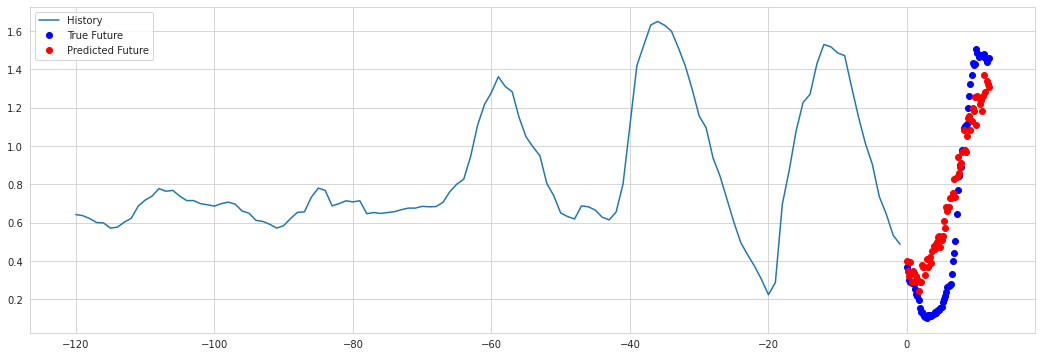

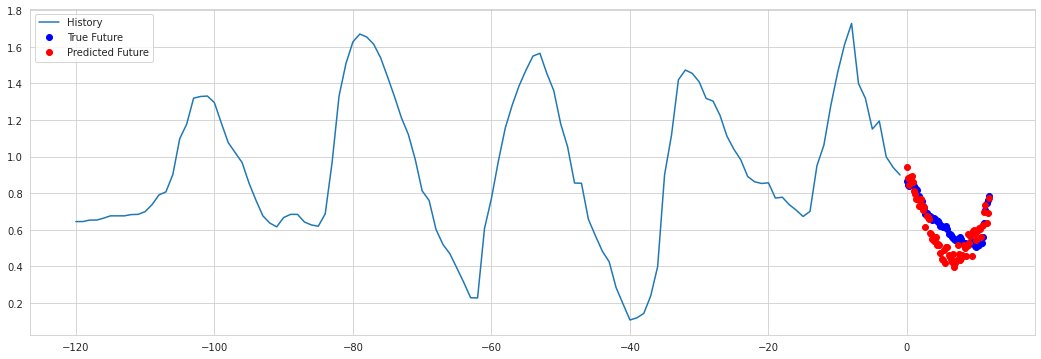

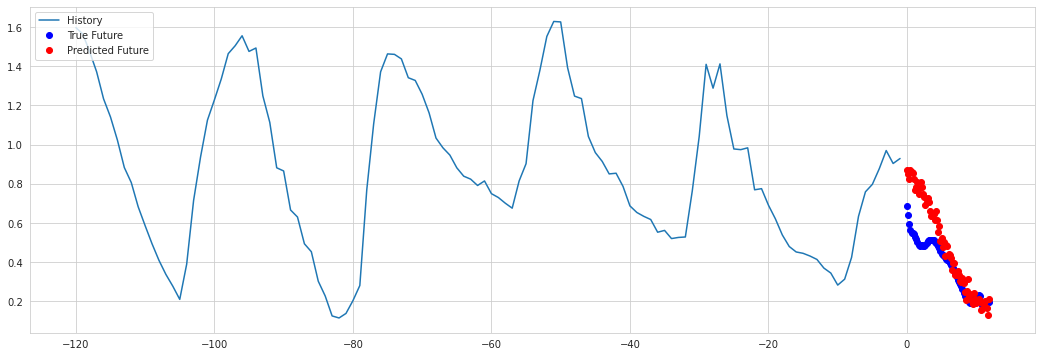

In [ ]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

## Multi-Step, Multi-Input, and Multi-Output

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

In [ ]:
def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis]

def multi_step_output_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    for i, (var, c) in enumerate(zip(features.columns[:2], ['b','r'])):
        plt.plot(num_in, np.array(history[:, i]), c, label=var)
        plt.plot(np.arange(num_out)/STEP, np.array(true_future[:,i]), c+'o', markersize=5, alpha=0.5,
               label=f"True {var.title()}")
        if prediction.any():
            plt.plot(np.arange(num_out)/STEP, np.array(prediction[:,i]), '*', markersize=5, alpha=0.5,
                     label=f"Predicted {var.title()}")
    
    plt.legend(loc='upper left')
    plt.show()


In [ ]:
future_target = 72
x_train_multi, y_train_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:,:2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:, :2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [ ]:
print (x_train_multi.shape,
       y_train_multi.shape,
       x_val_multi.shape,
       y_val_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target temperature to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(299280, 120, 2, 1, 1)
(299280, 72, 2, 1, 1)
(119759, 120, 2, 1, 1)
(119759, 72, 2, 1, 1)
Single window of past history : (120, 2, 1, 1)
Target temperature to predict : (72, 2, 1, 1)


In [ ]:
BATCH_SIZE = 128

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

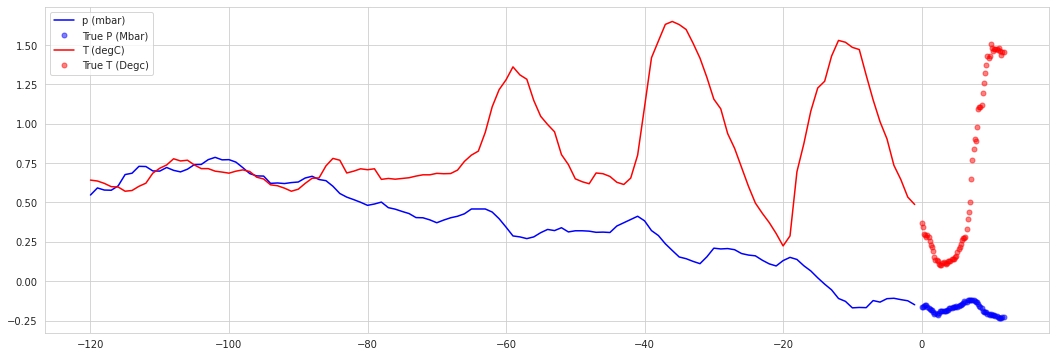

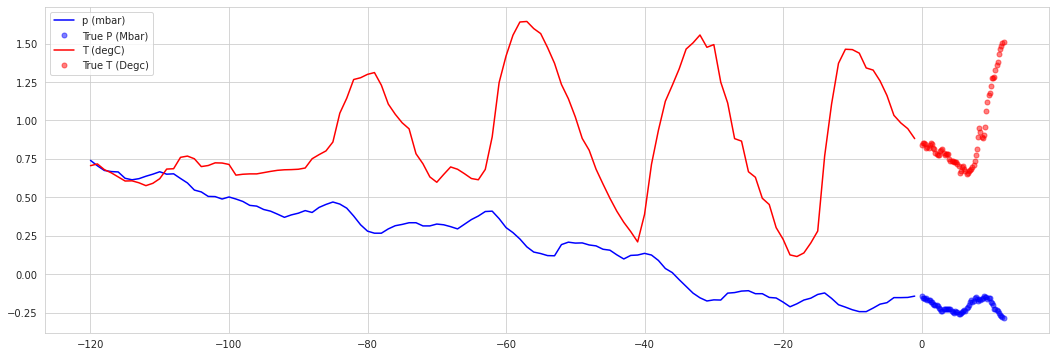

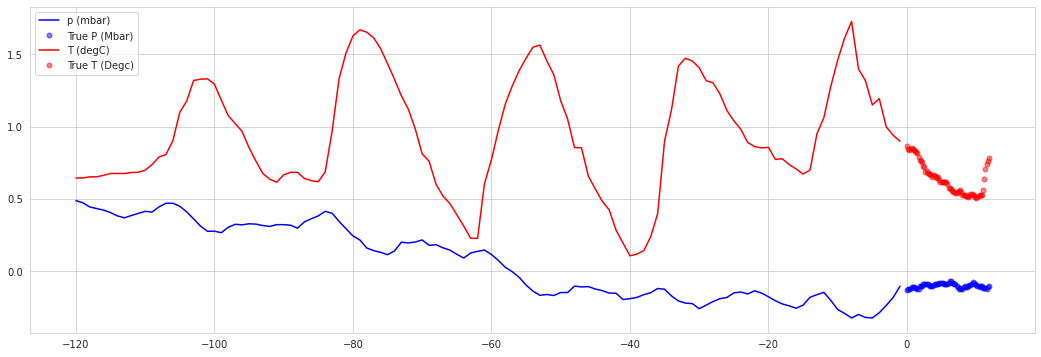

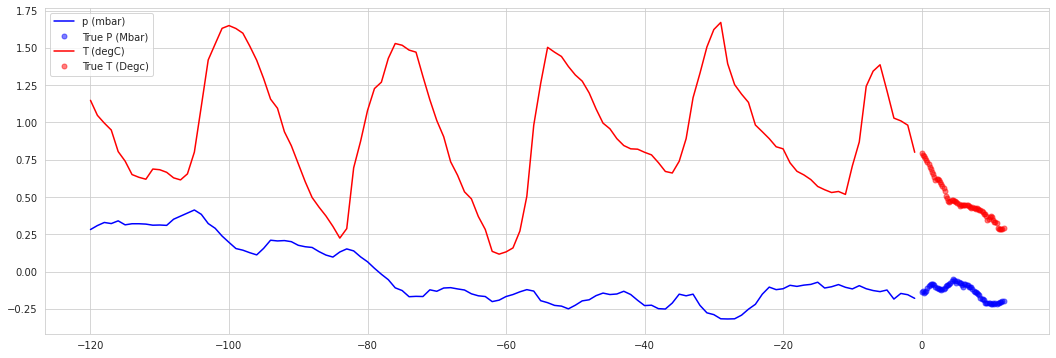

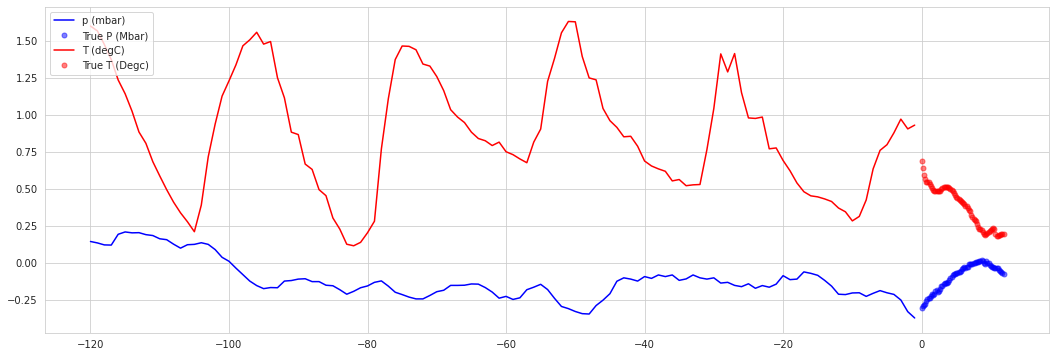

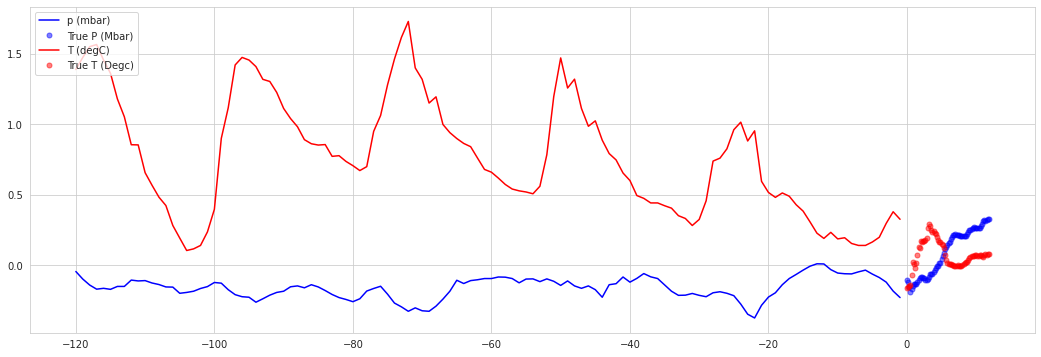

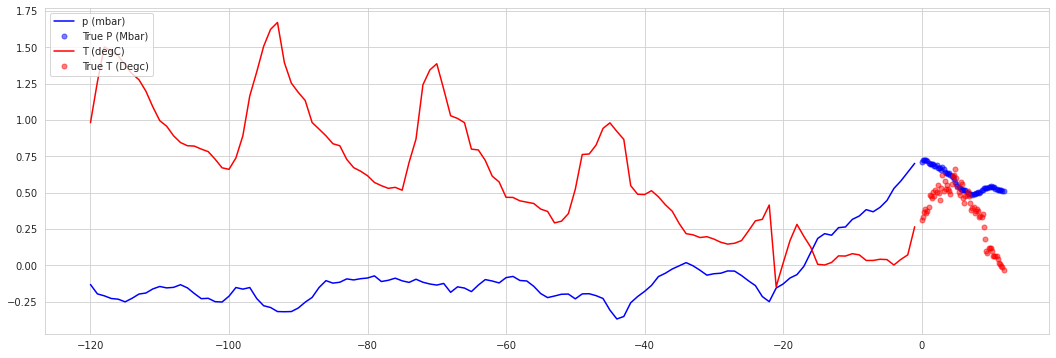

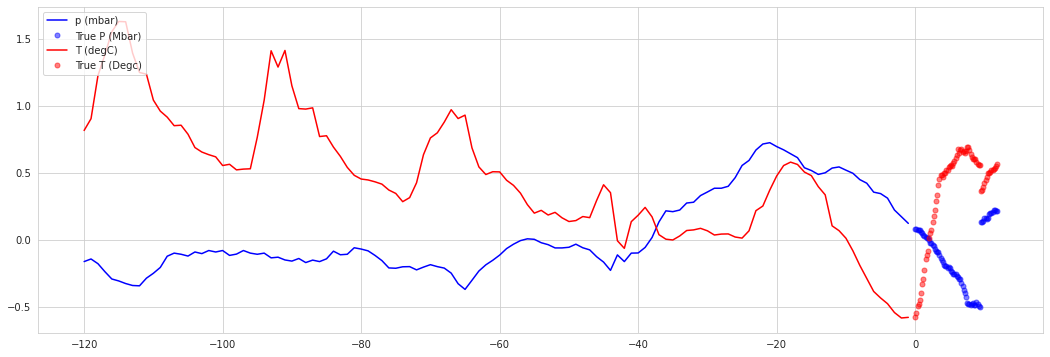

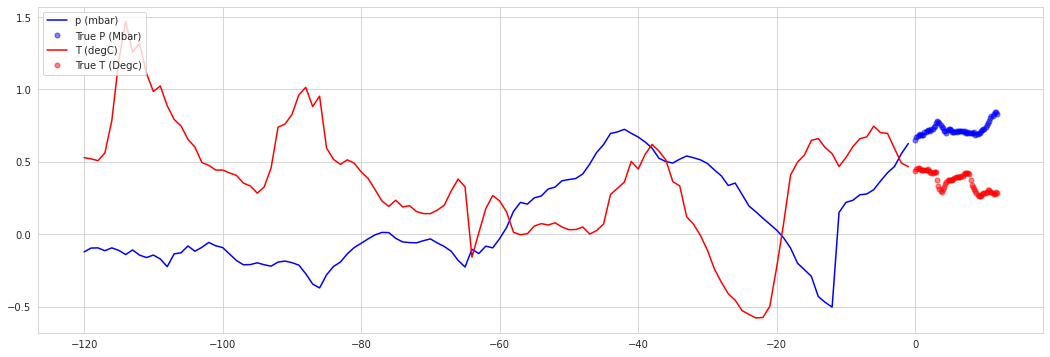

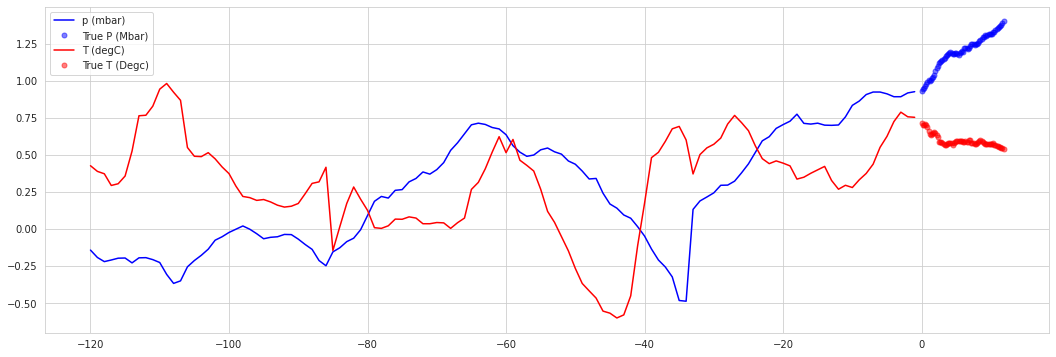

In [ ]:
for x, y in val_data_multi.take(10):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.array([0]))

## Convolutional LSTM

In [ ]:
def build_model(input_timesteps, output_timesteps, num_links, num_inputs):
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    
    model.add(Dropout(0.20, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.20, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2', activation = 'linear'))

#     optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#     optimizer = tf.keras.optimizers.Adam(0.1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.004, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model


In [ ]:
future_target = 72
x_train_multi, y_train_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:,:2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:, :2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

BATCH_SIZE = 128

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


In [ ]:
EPOCHS = 10
steps_per_epoch = 200
validation_steps = 2

modelstart = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
model = build_model(x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2])
print(model.summary())

# Train
print("\nTRAIN MODEL...")
history = model.fit(train_data_multi,
                    epochs = EPOCHS,
                    validation_data=val_data_multi,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping])
model.save('multi-output-timesteps.h5')
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 120, 2, 1, 1)      4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 120, 2, 1, 64)     166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 2, 1, 64)     0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 120, 2, 1, 64)     256       
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 2, 1, 64)          164096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 1, 64)          0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 2, 1, 64)         

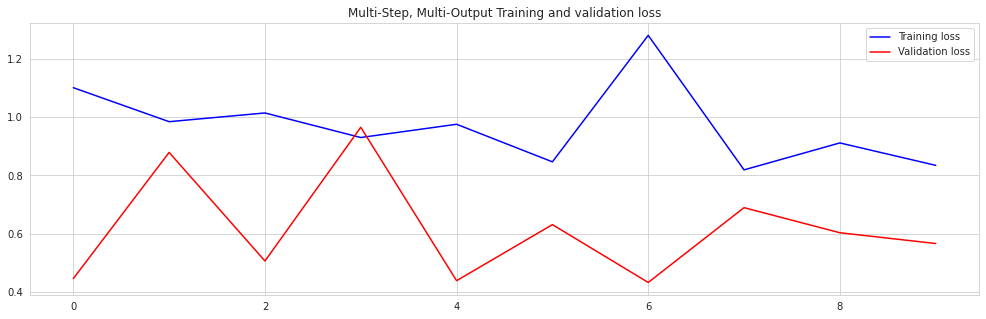

In [ ]:
plot_train_history(history, 'Multi-Step, Multi-Output Training and validation loss')

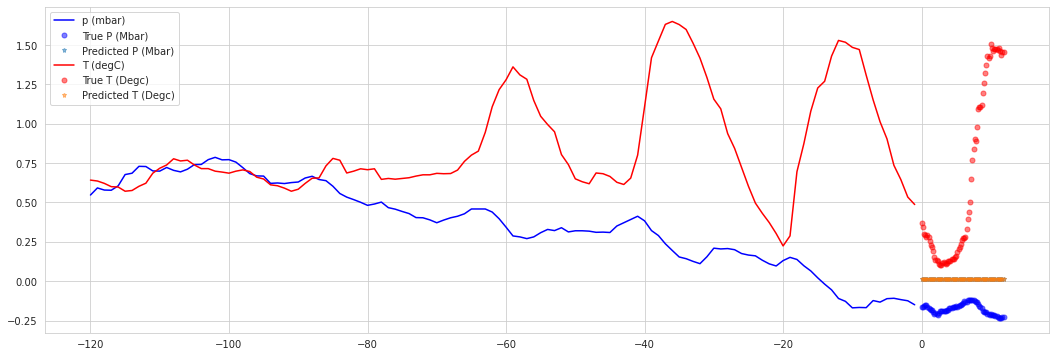

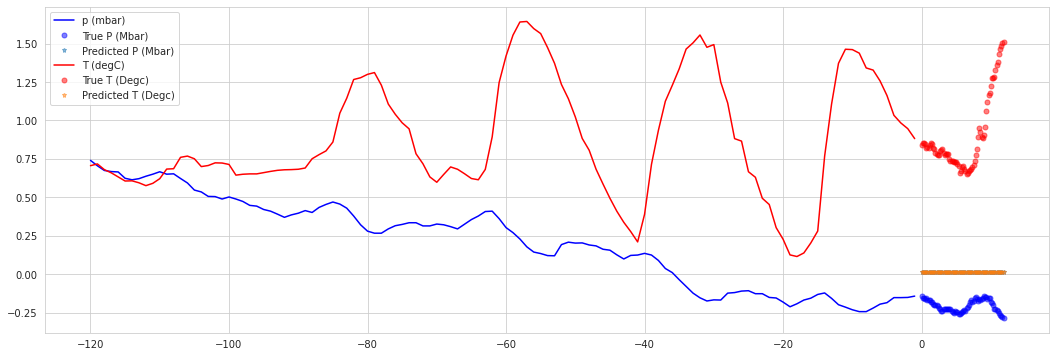

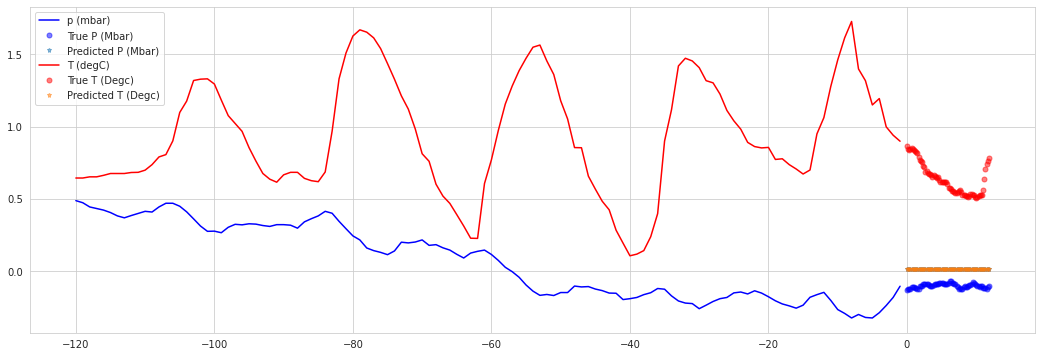

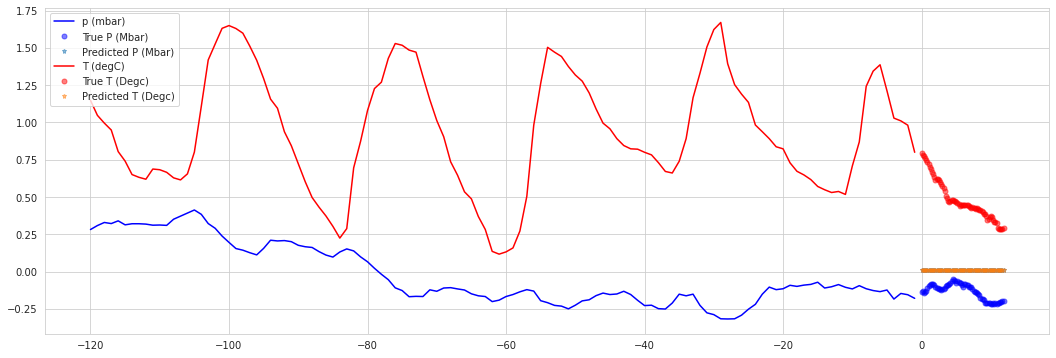

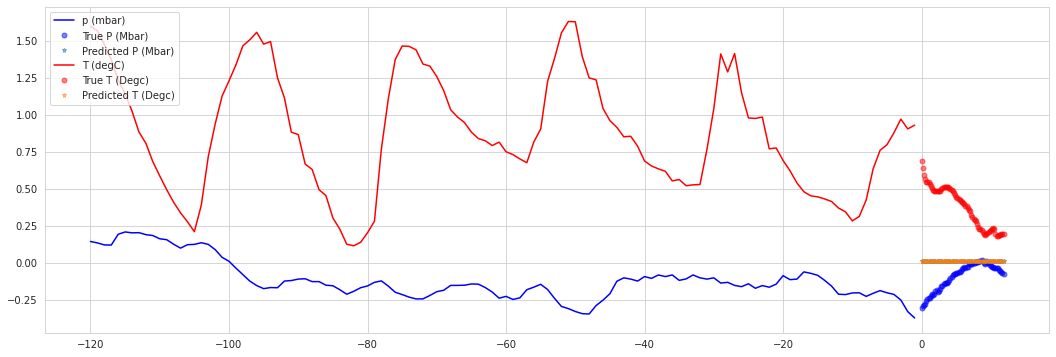

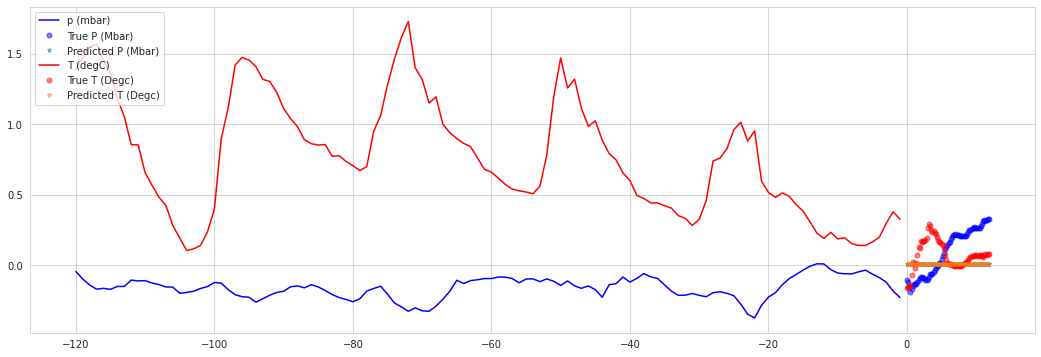

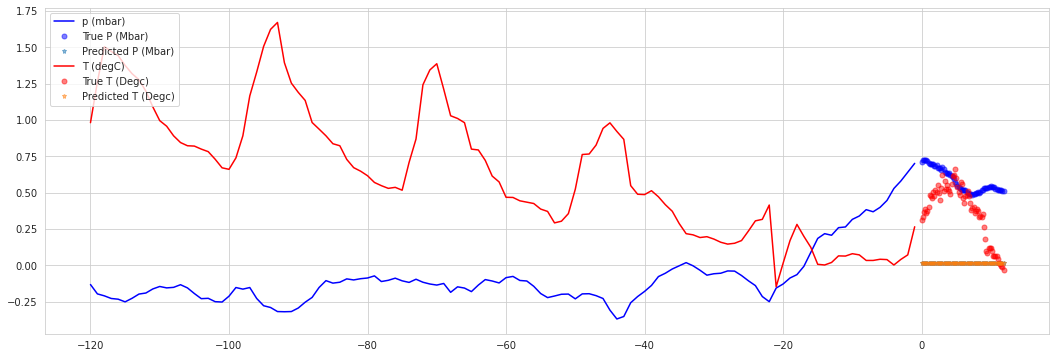

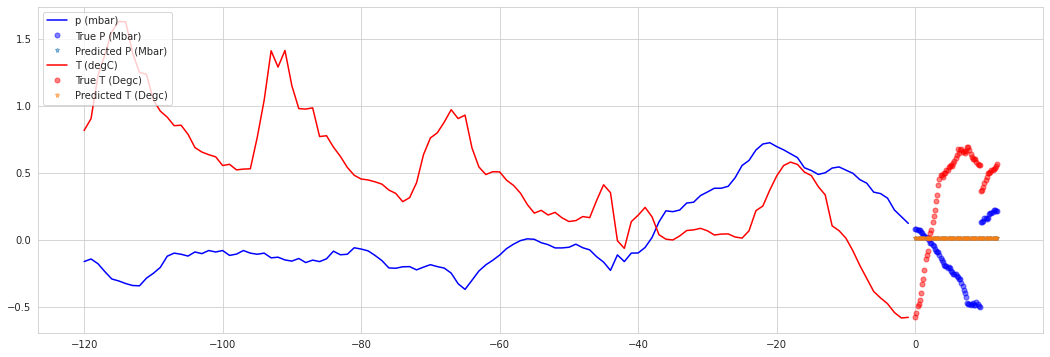

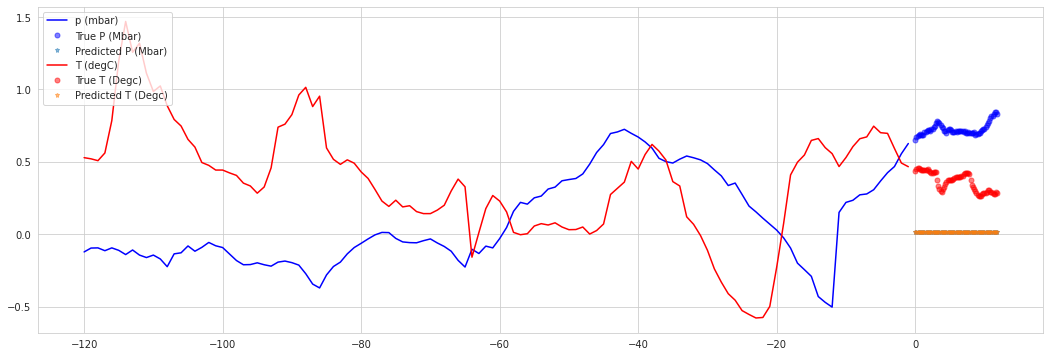

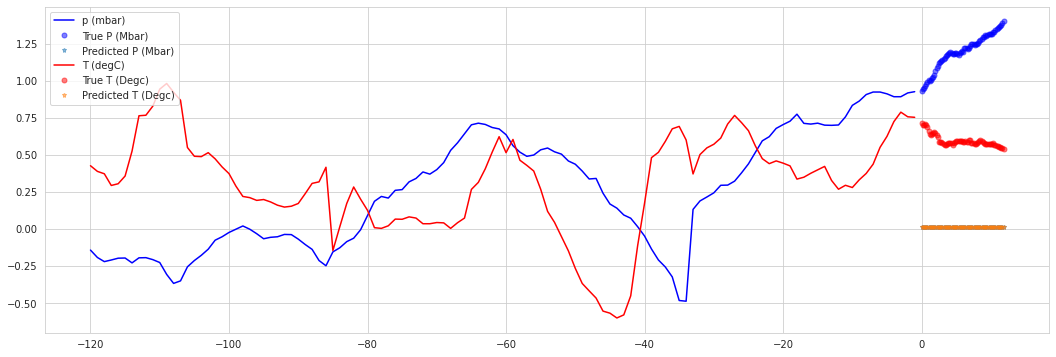

In [ ]:
for x, y in val_data_multi.take(10):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:])))


## Simplified Convolutional LSTM

In [ ]:
def build_model(input_timesteps, output_timesteps, num_links, num_inputs):    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = False))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

#     model.add(ConvLSTM2D(name ='conv_lstm_2',
#                          filters = 64, kernel_size = (5, 1), 
#                          padding='same',
#                          return_sequences = False))
    
#     model.add(Dropout(0.20, name = 'dropout_2'))
#     model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
#     model.add(ConvLSTM2D(name ='conv_lstm_3',
#                          filters = 64, kernel_size = (10, 1), 
#                          padding='same',
#                          return_sequences = True))
    
#     model.add(Dropout(0.20, name = 'dropout_3'))
#     model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2'))

#     optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#     optimizer = tf.keras.optimizers.Adam(0.1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.003, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

In [ ]:
# Extend Prediction Window..
future_target = 144
x_train_multi, y_train_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:,:2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:, :2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

BATCH_SIZE = 128

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [64]:
EPOCHS = 10
steps_per_epoch = 200
validation_steps = 2

modelstart = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
model = build_model(x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2])
print(model.summary())

# Train
print("\nTRAIN MODEL...")
history = model.fit(train_data_multi,
                    epochs = EPOCHS,
                    validation_data=val_data_multi,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping])
model.save('multi-output-timesteps.h5')
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 120, 2, 1, 1)      4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 2, 1, 64)          166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 1, 64)          0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 2, 1, 64)          256       
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 144, 128)          0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 144, 2, 1, 64)    

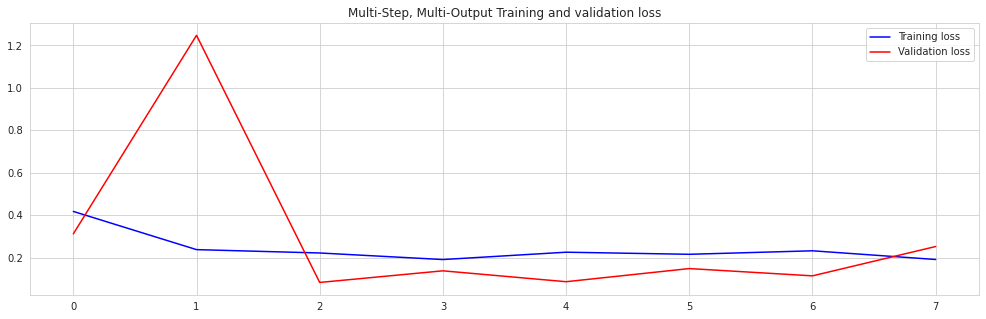

In [65]:
plot_train_history(history, 'Multi-Step, Multi-Output Training and validation loss')

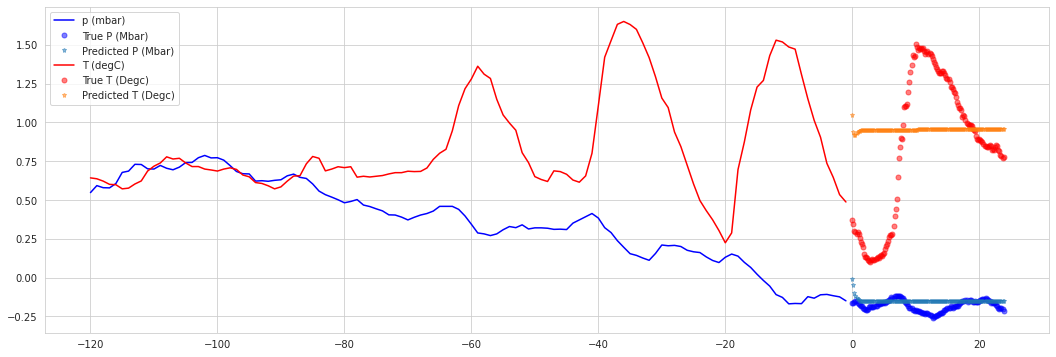

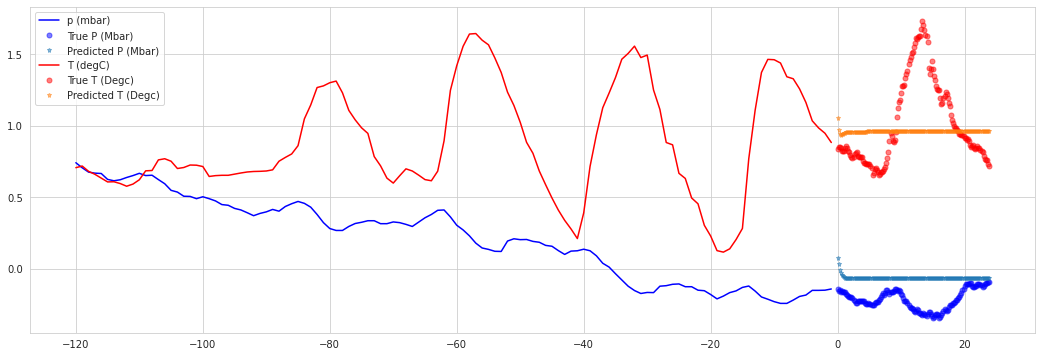

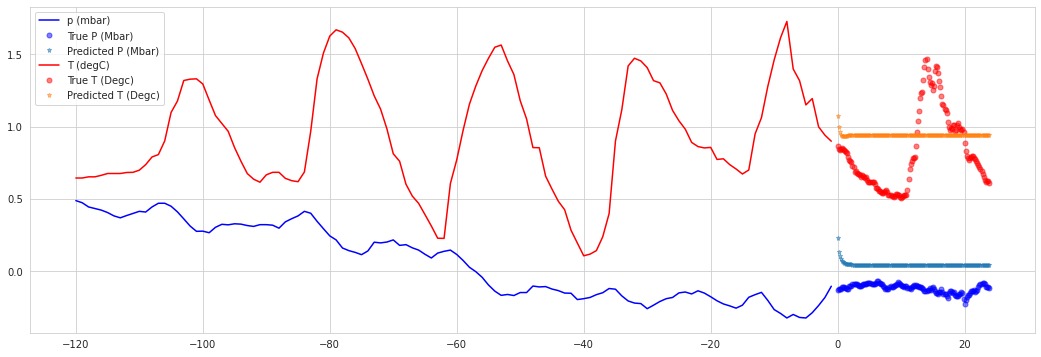

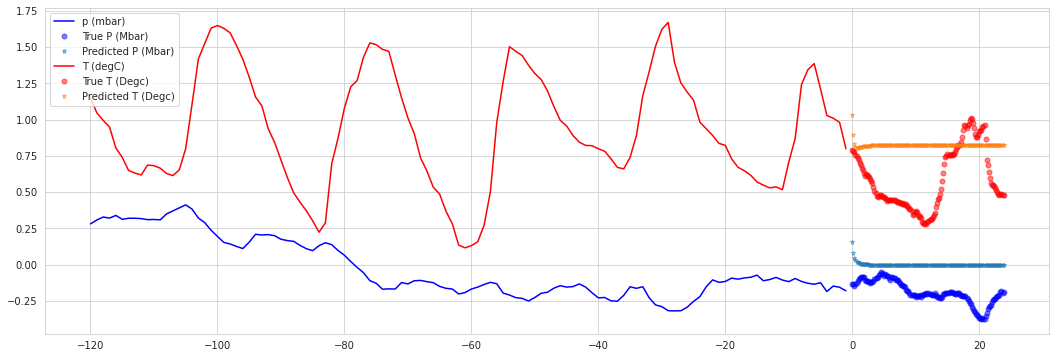

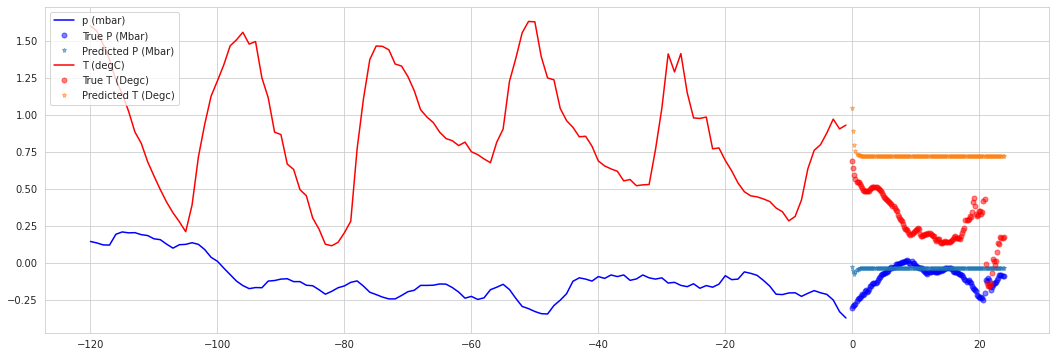

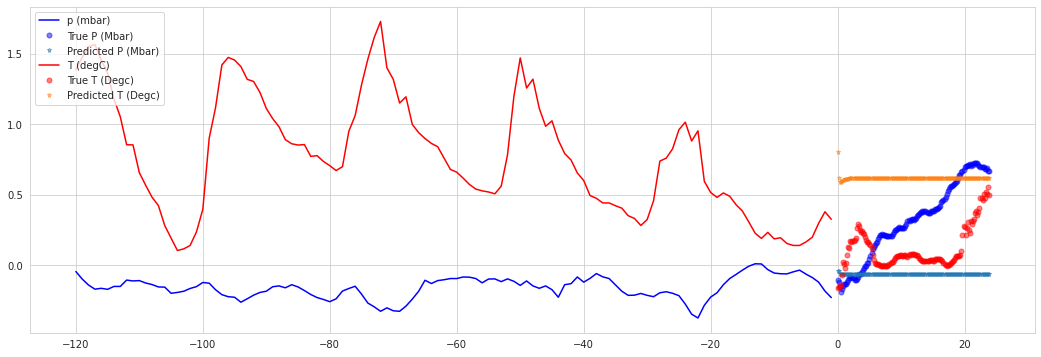

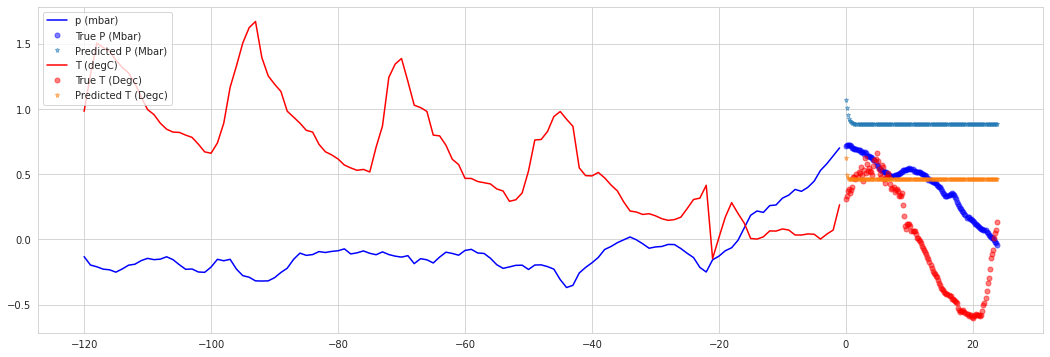

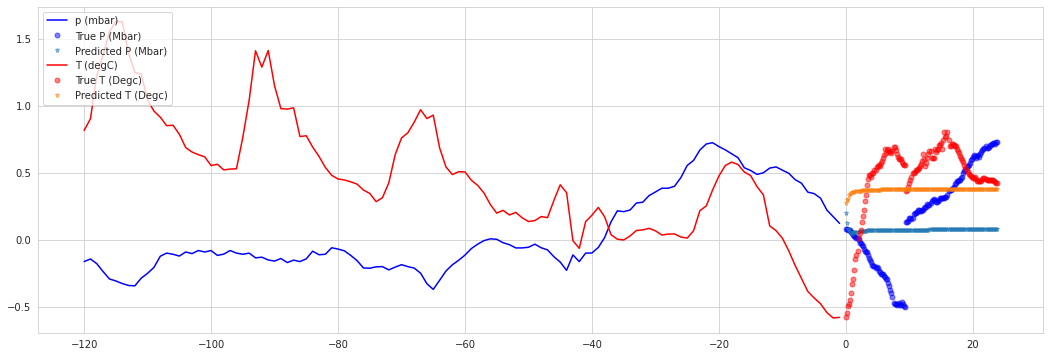

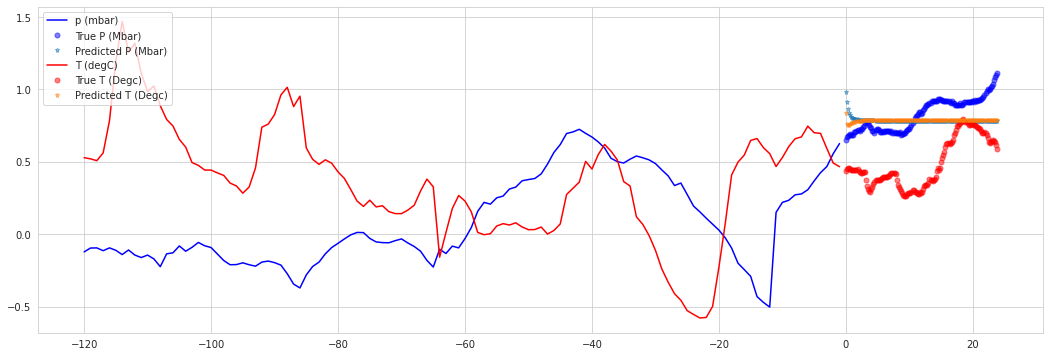

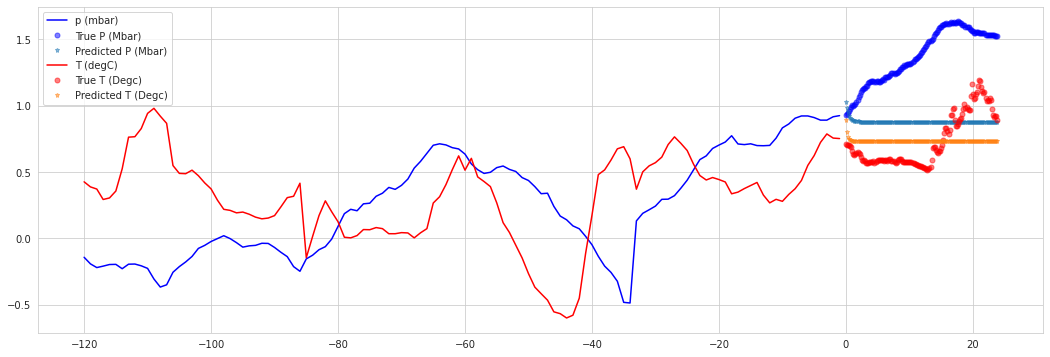

In [66]:
for x, y in val_data_multi.take(10):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:])))